# i. Introduction

- Name: Stanly Sukmajaya
- Batch: RMT-036
- Dataset: multiTimeline.csv

This dataset contains the data of popularity level of a tourism place in Indonesia called Pari Island. If the value is 0, it means there's no data, 50 means it's only half popular, and 100 means it's very popular. This means the data should only range from 0 to 100.

Objective: Predict the level of popularity each week for the next 1 year, the weeks after the data ends.

# ii. Import Libraries

In [55]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# iii. Data Loading

In [56]:
timeline_original = pd.read_csv("multiTimeline.csv")
timeline = timeline_original.copy()
timeline.rename(columns={"Pulau Pari: (Indonesia)": "Value", "Week": "Date"}, inplace=True)
timeline.set_index("Date", inplace=True)
timeline.index = pd.to_datetime(timeline.index)

In [57]:
train_length = int(timeline.shape[0] * 0.8)
train = timeline[:train_length]
test = timeline[train_length:]

# iv. Exploratory Data Analysis (EDA)

## 1. Time Series Line Plot

Text(0, 0.5, 'value')

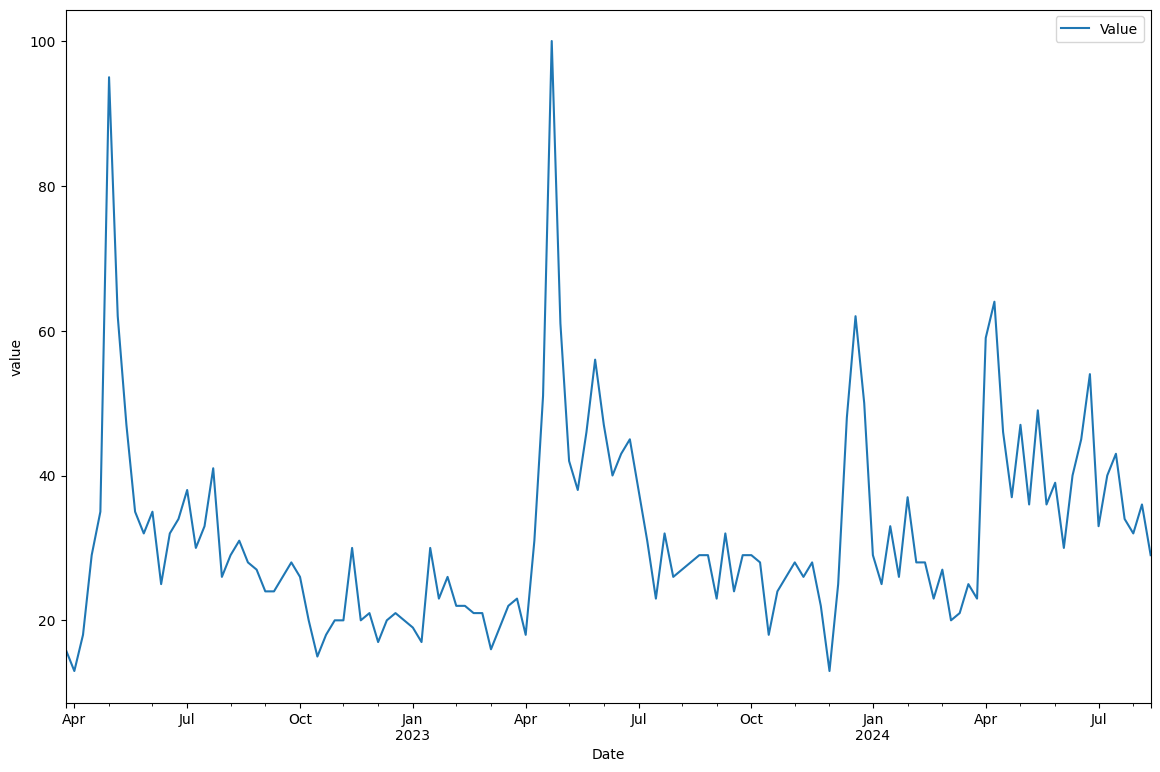

In [58]:
timeline.plot()
plt.xlabel('Date')
plt.ylabel('value')

From the line plot above, we can conclude that the data has yearly pattern, and it seems to reach its peak in the month of May. After the month of May, it gradually decreases, and then goes on to go up and down again for the next months, until it reaches its peak again in May next year. This pattern seems to continue.

## 2. Time Series Decomposition

### Decomposition using additive model

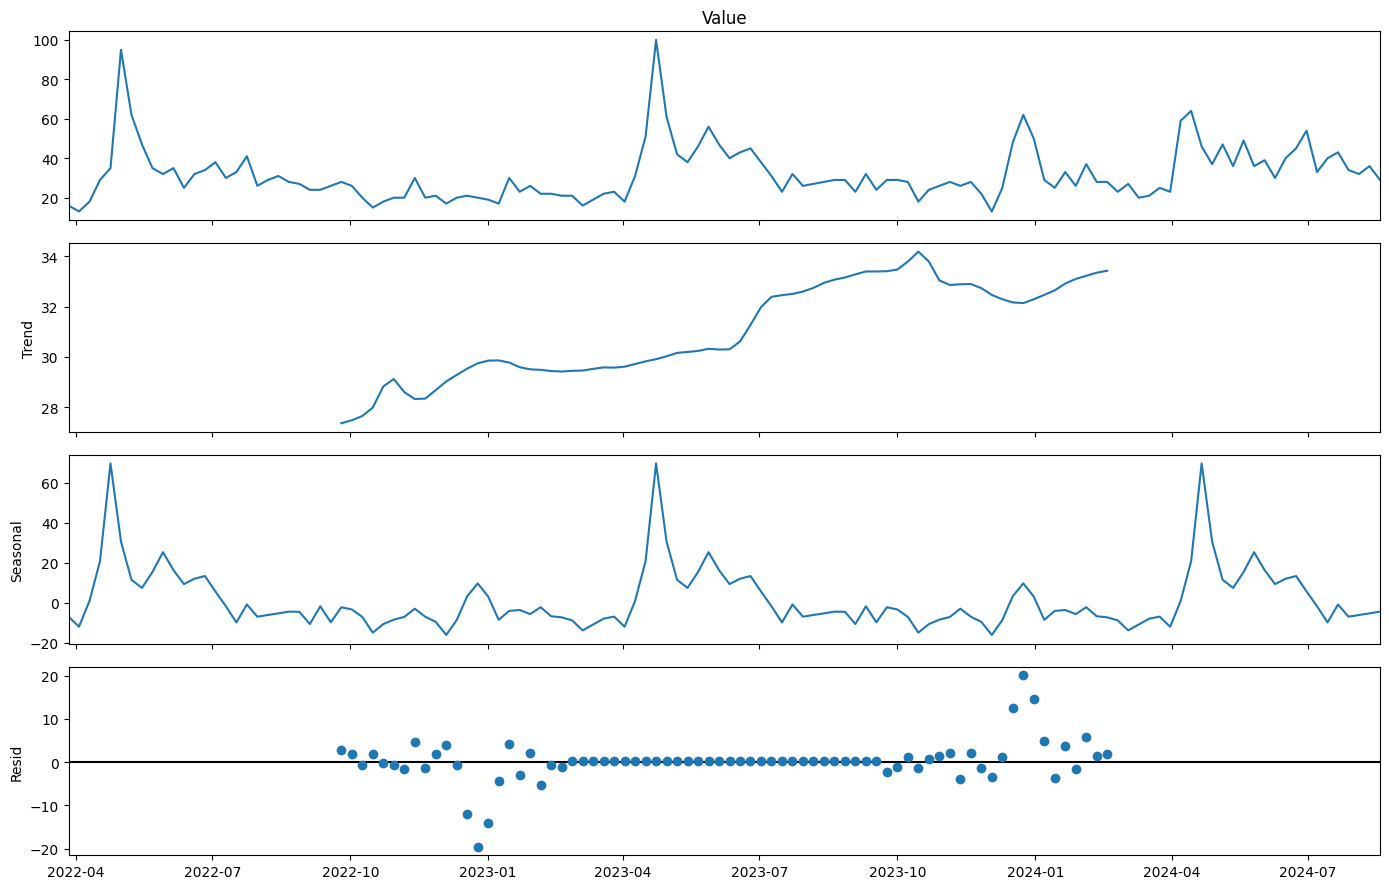

In [59]:
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(timeline['Value'], model='additive')
ax=res.plot()
plt.show()

### Decomposition using multiplicative

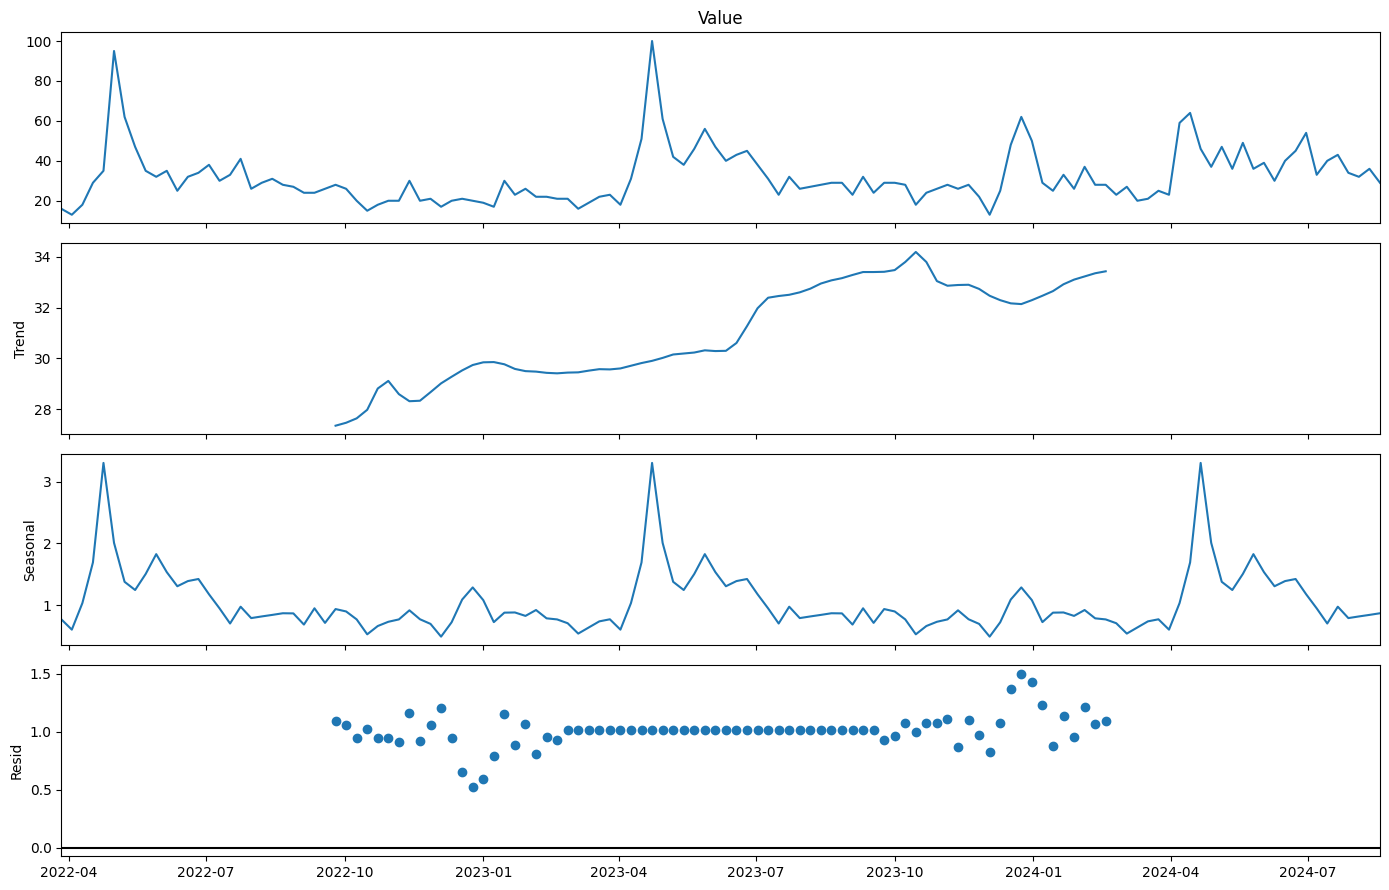

In [60]:
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(timeline['Value'], model='multiplicative')
ax=res.plot()
plt.show()

From the decomposition plots above, we can conclude that additive model seems to be the better model, compared to multiplicative, as it has a lot more data that's in line with the residual. For the seasonal, we can safely conclude that it has yearly pattern, so the seasonal argument should be 52, as 1 year has 52 weeks.

## 3. Stationarity Test

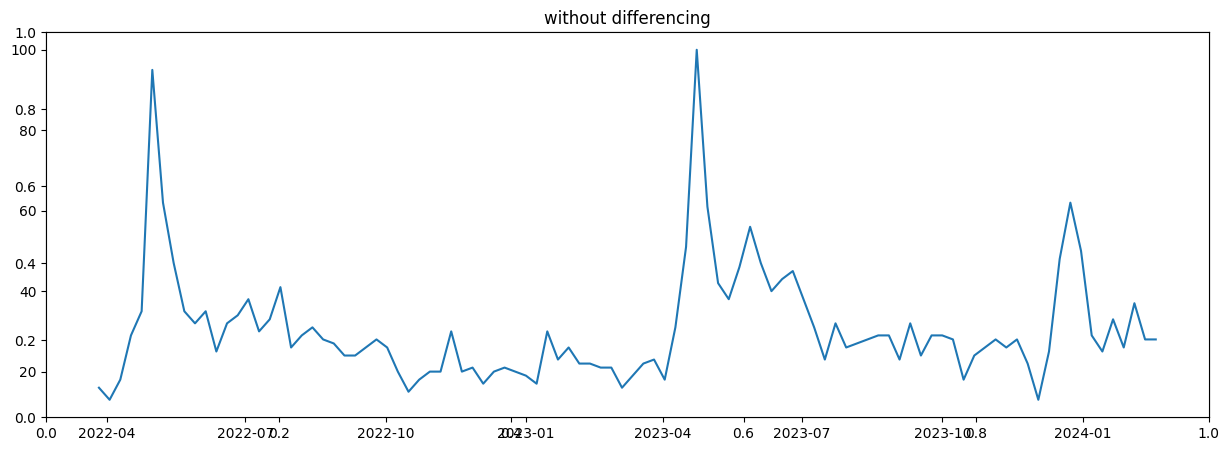

In [61]:
# Plot without differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('without differencing')
ax1.plot(train['Value'])

From the plot above, we can see that the data is already quite stationaire.

In [62]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

Check the stationarity of train value.

In [63]:
# Check stationarity of the dataset

check_stationarity(train['Value'])

ADF Statistic: -3.470815
p-value: 0.008769
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Stationary


It's already stationaire! Let's check if we do one level of differencing.

In [64]:
# Perform first-order differencing

diff1 = train['Value'].diff()
diff1

Date
2022-03-27     NaN
2022-04-03    -3.0
2022-04-10     5.0
2022-04-17    11.0
2022-04-24     6.0
              ... 
2024-01-21     8.0
2024-01-28    -7.0
2024-02-04    11.0
2024-02-11    -9.0
2024-02-18     0.0
Name: Value, Length: 100, dtype: float64

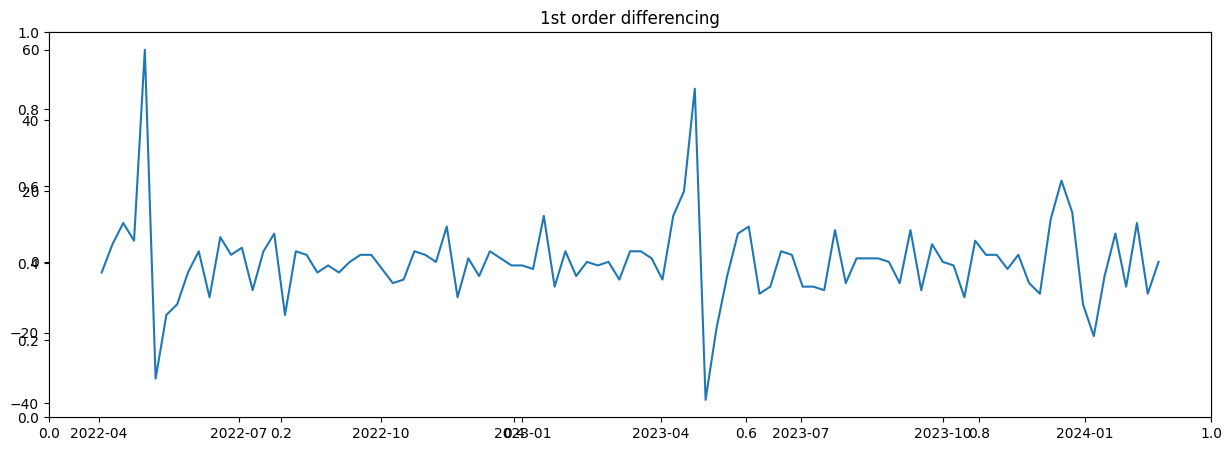

In [65]:
# Plot the result after first-order differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('1st order differencing')
ax1.plot(diff1)

Looks a bit more stationaire if we do one level of differencing.

In [66]:
# Check stationarity after performing first-order differencing

print("1st order differencing")
check_stationarity(diff1.dropna())

1st order differencing
ADF Statistic: -8.411029
p-value: 0.000000
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Stationary


After doing 1 level of differencing, we can see that the p-value has decreased, but the 5% value is still the same. We will stick with the data without any differencing, as it was already stationaire and has a good p-value. That means, the parameter `d` will be 0, as we don't need any differencing.

## 4. ACF and PACF Plot

We will do ACF and PACF plotting with the train data without any differencing.

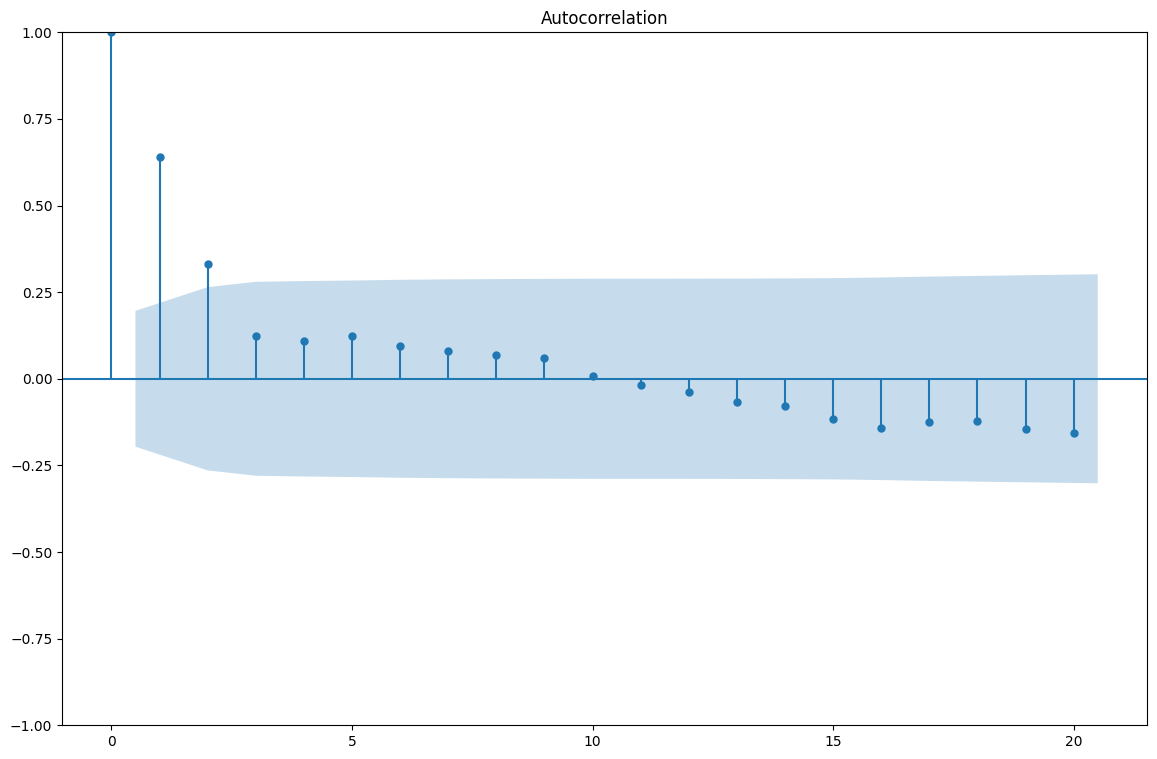

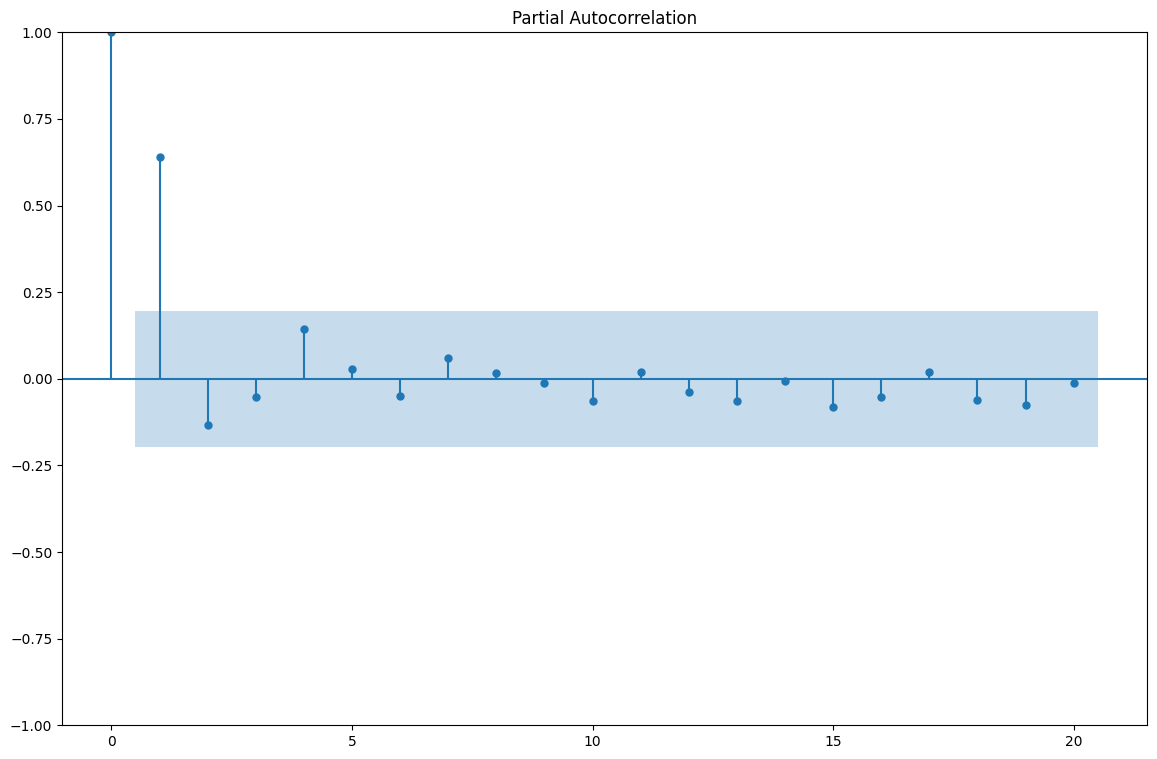

In [67]:
plot_acf(train['Value'])
plot_pacf(train['Value'])
plt.show()

From the plots above, we can conclude that `p` value should be 1 and `q` value should be 2. There are not really any other options, as other options are inside the low correlation threshold.

# v. Model Definition and Training

## 1. ARIMA

Showing the `test` data

In [68]:
test

,Value
Date,
2024-02-25,23
2024-03-03,27
2024-03-10,20
2024-03-17,21
2024-03-24,25
2024-03-31,23
2024-04-07,59
2024-04-14,64
2024-04-21,46


From the test data above, the first date shows `2024-02-25` and the last date shows `2024-08-18`. We will compare our prediction with the test data

Create the ARIMA model with train as the argument.    
Use the `start` argument with `2024-02-25` as it is the start data of our `test` and `end` argument with `2024-08-18` as it is the end data of our `test`.

In [69]:
# Train with p=1, d=0, q=2

arima_model = ARIMA(train['Value'], order=(1,0,2))  # p, d, q are your ARIMA parameters
arima = arima_model.fit()
arima_pred_test = arima.predict(start="2024-02-25", end="2024-08-18", dynamic=True)
arima_pred_test = pd.DataFrame(arima_pred_test)
arima_pred_test.columns = ['Value_Predicted_ARIMA']
act_vs_pred_arima = pd.concat([test, arima_pred_test], axis=1)
print(f"ARIMA model AIC: {arima.aic}")
act_vs_pred_arima

ARIMA model AIC: 766.7228895843174


,Value,Value_Predicted_ARIMA
2024-02-25,23,26.776014
2024-03-03,27,28.986563
2024-03-10,20,30.168584
2024-03-17,21,30.399407
2024-03-24,25,30.444481
2024-03-31,23,30.453283
2024-04-07,59,30.455002
2024-04-14,64,30.455338
2024-04-21,46,30.455403
2024-04-28,37,30.455416


From the dataframe above, we can see the actual value versus the predicted value using SARIMA model. Now we will draw the lineplot.

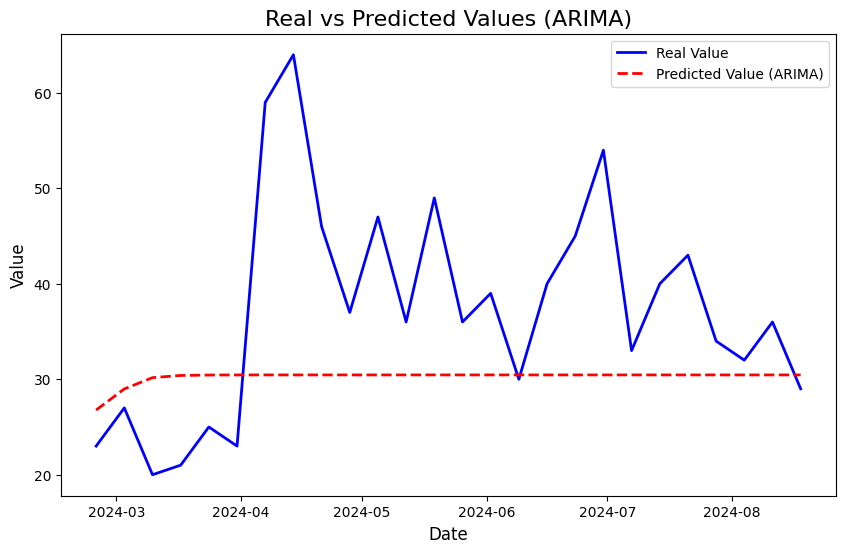

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(act_vs_pred_arima.index, act_vs_pred_arima['Value'], label='Real Value', color = 'blue', linewidth = 2)

plt.plot(act_vs_pred_arima.index, act_vs_pred_arima['Value_Predicted_ARIMA'], label='Predicted Value (ARIMA)', color = 'red', linestyle='--', linewidth=2)

plt.title('Real vs Predicted Values (ARIMA)', fontsize = 16)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Value', fontsize=12)

plt.legend()

plt.show()

From the lineplot above, we can see that ARIMA predicts in a linear fashion.

## 2. SARIMA

Now we will use the SARIMA model to build our prediction. `p` value is 1, `d` value is 0, `q` value is 2, and `s` value is 52.

In [71]:
sarima = SARIMAX(train['Value'], order=(1, 0, 2),seasonal_order=(1, 0, 2, 52)).fit()
sarima.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91112D+00    |proj g|=  4.34481D-02

At iterate    5    f=  3.87712D+00    |proj g|=  1.17072D-01

At iterate   10    f=  3.87008D+00    |proj g|=  7.61657D-03

At iterate   15    f=  3.86685D+00    |proj g|=  1.34631D-03

At iterate   20    f=  3.86673D+00    |proj g|=  1.93546D-03

At iterate   25    f=  3.86581D+00    |proj g|=  6.09071D-03

At iterate   30    f=  3.86547D+00    |proj g|=  8.00837D-03

At iterate   35    f=  3.86519D+00    |proj g|=  5.48826D-03

At iterate   40    f=  3.86504D+00    |proj g|=  3.43983D-03

At iterate   45    f=  3.86501D+00    |proj g|=  1.34541D-03

At iterate   50    f=  3.86500D+00    |proj g|=  1.45164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                  100
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 52)   Log Likelihood                -386.500
Date:                            Mon, 21 Oct 2024   AIC                            787.000
Time:                                    12:16:34   BIC                            805.236
Sample:                                03-27-2022   HQIC                           794.381
                                     - 02-18-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9836      0.038     26.222      0.000       0.910       1.057
ma.L1         -0.2662      0.154     -1.730      0.084      -0.568       0.035
ma.L2         -0.3030      0.209     -1.450      0.147      -0.713       0.107
ar.S.L52       0.8683    232.982      0.004      0.997    -455.767     457.504
ma.S.L52      -1.4242    421.977     -0.003      0.997    -828.485     825.636
ma.S.L104      0.9584    152.023      0.006      0.995    -297.001     298.918
sigma2        58.5540     18.103      3.234      0.001      23.073      94.035
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):              1202.55
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             3.33
Prob(H) (two-sided):                  0.01   Kurtosis:                        18.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+19. Standard errors may be unstable.
"""

In [72]:
## Predict test-set
sarima_pred_test = sarima.predict(start="2024-02-25", end="2024-08-18", dynamic=True)
sarima_pred_test = pd.DataFrame(sarima_pred_test)
sarima_pred_test.columns = ['Value_Predicted_SARIMA']

## Concate with actual test-set
act_vs_pred_sarima = pd.concat([test, sarima_pred_test], axis=1)
print(f"SARIMA AIC value: {sarima.aic}")
act_vs_pred_sarima

SARIMA AIC value: 787.0003058389359


,Value,Value_Predicted_SARIMA
2024-02-25,23,30.035650
2024-03-03,27,29.512558
2024-03-10,20,29.222482
2024-03-17,21,27.890148
2024-03-24,25,25.000940
2024-03-31,23,23.533807
2024-04-07,59,25.342173
2024-04-14,64,29.644956
2024-04-21,46,31.681686
2024-04-28,37,56.979778


From the dataframe above, we can see the actual value versus the predicted value using SARIMA model. Now we will draw the lineplot.

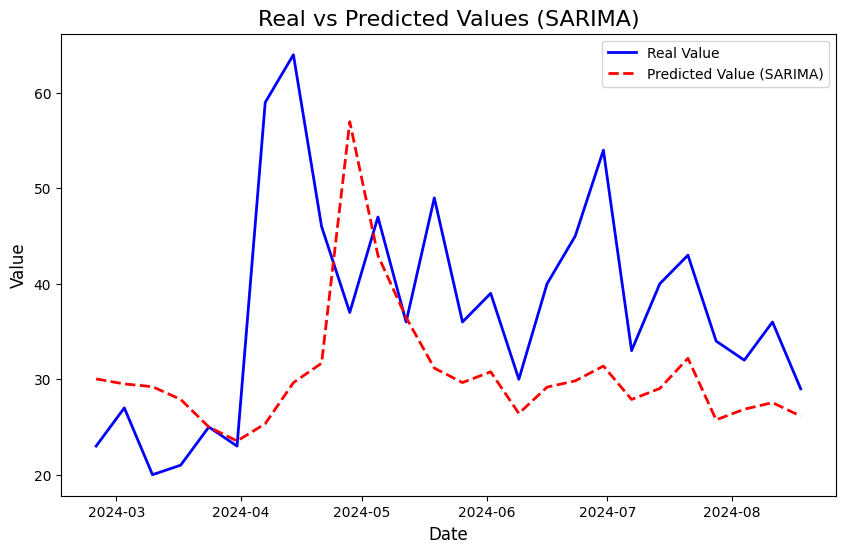

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(act_vs_pred_sarima.index, act_vs_pred_sarima['Value'], label='Real Value', color = 'blue', linewidth = 2)

plt.plot(act_vs_pred_sarima.index, act_vs_pred_sarima['Value_Predicted_SARIMA'], label='Predicted Value (SARIMA)', color = 'red', linestyle='--', linewidth=2)

plt.title('Real vs Predicted Values (SARIMA)', fontsize = 16)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Value', fontsize=12)

plt.legend()

plt.show()

From the line plot above, we can see that SARIMA, althought not really accurate, manages to predict the values without being completely linear like ARIMA.

# vi. Model Evaluation

Let's check the MAE and RMSE values of the ARIMA and SARIMA model that we've created and compare them with test.

In [74]:
print('MAE test ARIMA: ', mean_absolute_error(test, arima_pred_test))
print('RMSE test ARIMA: ', np.sqrt(mean_squared_error(test, arima_pred_test)))
print('MAPE test ARIMA: ', mean_absolute_percentage_error(test, arima_pred_test))

MAE test ARIMA:  10.074697842789448
RMSE test ARIMA:  13.055714144232265
MAPE test ARIMA:  0.24973687002214315


In [75]:
print('MAE test SARIMA: ', mean_absolute_error(test, sarima_pred_test))
print('RMSE test SARIMA: ', np.sqrt(mean_squared_error(test, sarima_pred_test)))
print('MAPE test SARIMA: ', mean_absolute_percentage_error(test, sarima_pred_test))

MAE test SARIMA:  10.352389563389677
RMSE test SARIMA:  13.667375485699898
MAPE test SARIMA:  0.2531588157658346


Based on MAE, MAPE and RMSE, it looks like our ARIMA model is slightly better than SARIMA, but it's so little that it might not matter. The lower the error value the better.

In [76]:
print(f"ARIMA AIC value: {arima.aic}")
print(f"SARIMA AIC value: {sarima.aic}")

ARIMA AIC value: 766.7228895843174
SARIMA AIC value: 787.0003058389359


From the AIC value, MAE and MAPE it looks like our ARIMA model is slightly better than SARIMA.

Now let's look at the data comparing the test values, and the predicted ARIMA and SARIMA values.

# vii. Model Inference

In [77]:
test_compare = pd.concat([act_vs_pred_arima, act_vs_pred_sarima.drop(columns=["Value"])], axis=1)
test_compare

,Value,Value_Predicted_ARIMA,Value_Predicted_SARIMA
2024-02-25,23,26.776014,30.035650
2024-03-03,27,28.986563,29.512558
2024-03-10,20,30.168584,29.222482
2024-03-17,21,30.399407,27.890148
2024-03-24,25,30.444481,25.000940
2024-03-31,23,30.453283,23.533807
2024-04-07,59,30.455002,25.342173
2024-04-14,64,30.455338,29.644956
2024-04-21,46,30.455403,31.681686
2024-04-28,37,30.455416,56.979778


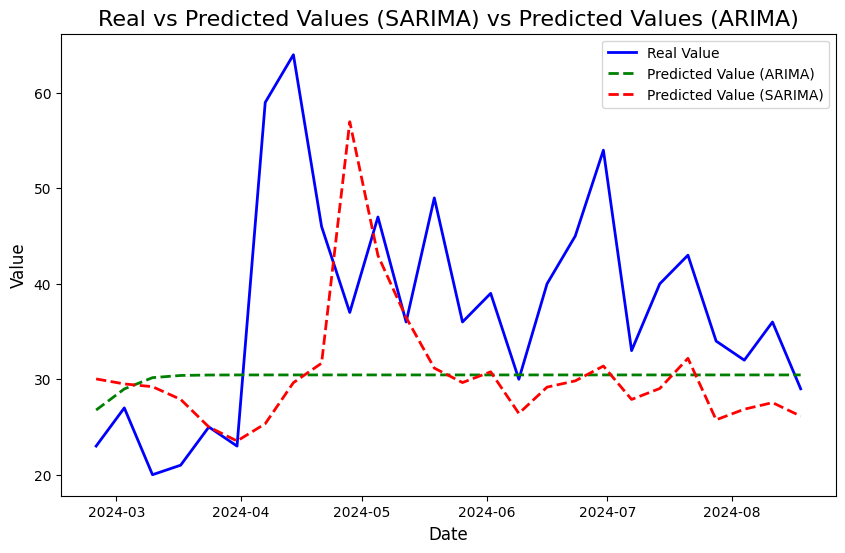

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(test_compare.index, test_compare['Value'], label='Real Value', color = 'blue', linewidth = 2)

plt.plot(test_compare.index, test_compare['Value_Predicted_ARIMA'], label='Predicted Value (ARIMA)', color = 'green', linestyle='--', linewidth=2)

plt.plot(test_compare.index, test_compare['Value_Predicted_SARIMA'], label='Predicted Value (SARIMA)', color = 'red', linestyle='--', linewidth=2)

plt.title('Real vs Predicted Values (SARIMA) vs Predicted Values (ARIMA)', fontsize = 16)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Value', fontsize=12)

plt.legend()

plt.show()

Although by MAE, RMSE and AIC, ARIMA seems to be slightly better, it doesn't predict quite well, as it has the same value from `2024-05-05` to `2024-08-18`. From the data and lineplot above it can be concluded that SARIMA is a better model.

Now we will look at the last 5 data of our timeline data.

In [79]:
timeline.tail()

,Value
Date,
2024-07-21,43
2024-07-28,34
2024-08-04,32
2024-08-11,36
2024-08-18,29


The last date is `2024-08-18`. We will create our prediction in the next 1 year every week, after `2024-08-18`. We will also compare the actual values with the ARIMA and SARIMA models prediction that we've created.

In [80]:
len_dataset = timeline.shape[0]
len_predict = len_dataset + 52

new_pred_arima = arima.predict(len_dataset, len_predict)
new_pred_arima = pd.DataFrame(new_pred_arima)
new_pred_arima.columns = ['Value_ARIMA']

new_pred_sarima = sarima.predict(len_dataset, len_predict)
new_pred_sarima = pd.DataFrame(new_pred_sarima)
new_pred_sarima.columns = ['Value_SARIMA']

pred_combined = pd.concat([new_pred_arima, new_pred_sarima], axis=1)
print("---- SARIMA and ARIMA future values prediction ----")
pred_combined

---- SARIMA and ARIMA future values prediction ----


,Value_ARIMA,Value_SARIMA
2024-08-25,30.455419,25.580422
2024-09-01,30.455419,24.215237
2024-09-08,30.455419,24.033902
2024-09-15,30.455419,24.795168
2024-09-22,30.455419,25.486992
2024-09-29,30.455419,24.524762
2024-10-06,30.455419,21.885910
2024-10-13,30.455419,19.722960
2024-10-20,30.455419,20.845513
2024-10-27,30.455419,21.572745


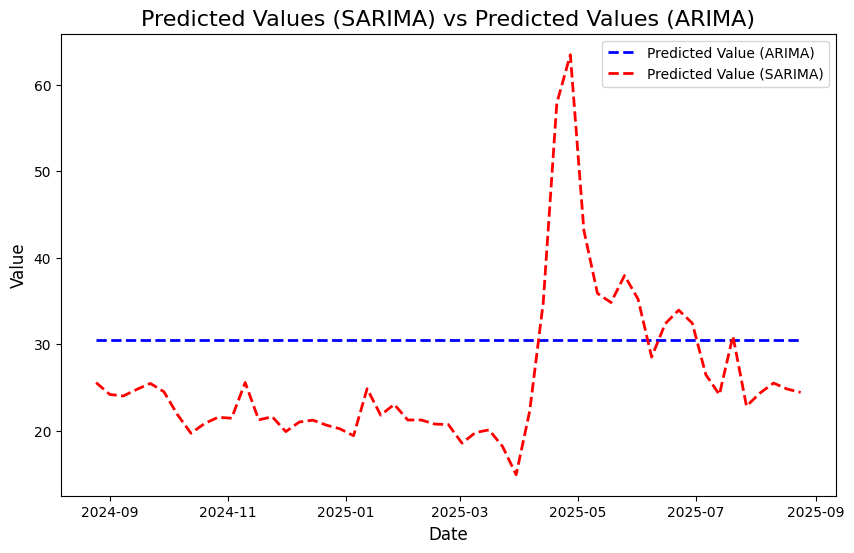

In [81]:
plt.figure(figsize=(10, 6))

plt.plot(pred_combined.index, pred_combined['Value_ARIMA'], label='Predicted Value (ARIMA)', color = 'blue', linestyle='--', linewidth=2)

plt.plot(pred_combined.index, pred_combined['Value_SARIMA'], label='Predicted Value (SARIMA)', color = 'red', linestyle='--', linewidth=2)

plt.title('Predicted Values (SARIMA) vs Predicted Values (ARIMA)', fontsize = 16)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Value', fontsize=12)

plt.legend()

plt.show()

From the values above we can safely conclude that SARIMA has better predictions than ARIMA, as ARIMA predicts the same value of `30.455419` every week for the next 1 year, while SARIMA doesn't and it has difference of AIC, MAE, MAPE and RMSE by very little.

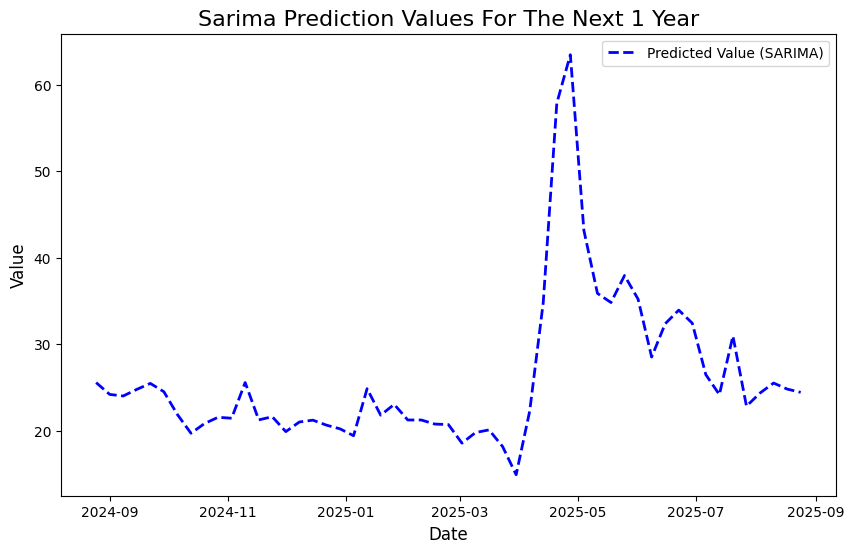

In [82]:
plt.figure(figsize=(10, 6))

plt.plot(pred_combined.index, pred_combined['Value_SARIMA'], label='Predicted Value (SARIMA)', color = 'blue', linestyle='--', linewidth=2)

plt.title('Sarima Prediction Values For The Next 1 Year', fontsize = 16)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Value', fontsize=12)

plt.legend()

plt.show()

SARIMA line plot values prediction for the next 1 year.

# viii. Conclusion

From the lineplot of the original data, it could be seen that the data has a 1 yearly pattern. However, we want to make sure of its seasonality by using Time Series Decomposition, and it indeed confirmed it has a 1 yearly pattern. From here, we can conclude that the `seasonal` argument that will be used in the model definition and training will be `52`, as the data is weekly, and there are `52` weeks in a year. For Time Series Decomposition, using `additive` model is better than `multiplicative` as in `additive` a lot more data lies in the residual line, than `multiplicative`.

Differencing technique was not necessary, as the data was already stationaire the first time we checked its stationarity, with the pvalue being very low (0.008769). From plotting the original data with ACF and PACF plot, we can safely conclude that the `p` argument should be `1` and `q` argument should be `2`, as it will be used in the model definition and training.

When it comes to the model definition, we use p as `1`, d as `0` (as no differencing was needed), q as `2` and s as `52` from the Time Series Decomposition, ACF and PACF plot findings that we have done. Comparing the model definitions by AIC, MAE and RMSE, ARIMA model seems to be slightly better (by very little) than SARIMA, however when we look at the real values and the line plots, ARIMA model seems to predict the same values most of the time, and predicts the same values for the dates after the `test` data, while SARIMA has different values for each prediction. With this, we can conclude that SARIMA is the better model than ARIMA.